# PSF Extractor
---

#### Overview
PSF extractor walkthrough

#### Libraries

In [27]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

#### Get that spicy colormap

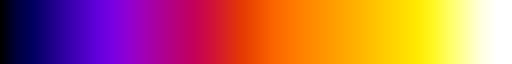

In [3]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

## 1) Find features
---
First step of workflow is to find features within a 3D image stack. Features are found using `trackpy.locate`, which takes the expected feature diameters and a minimum mass as input. The expected feature diameters are in pixel dimensions, and ought to be rounded up to the nearest odd integer. The minimum mass is the minimum "integrated brightness" which is used as a parameter to filter out spurious features.

In [42]:
import trackpy
from skimage import exposure
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from psf_extractor import get_stack

### Set parameters
Trackpy takes expected feature diameters in (x, y, z) as input. Requires input diameters to be odd and recommends rounding up.

In [5]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set expected feature diameters [nm]
dx_nm = 800
dy_nm = dx_nm
dz_nm = 1500

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer
diameters = np.ceil([dz, dy, dx]).astype(int) // 2 * 2 + 1

# Set candidate minimum masses
min_masses = [50, 100, 500, 1000, 2000, 5000]

### Create stack

In [6]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = get_stack(file_pattern)

INFO:root:Creating stack from directory.
INFO:root:Reading image file (1/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0000.png
INFO:root:Reading image file (2/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0001.png
INFO:root:Reading image file (3/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0002.png
INFO:root:Reading image file (4/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0003.png
INFO:root:Reading image file (5/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0004.png
INFO:root:Reading image file (6/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0005.png
INFO:root:Reading image file 

(32, 2048, 2448)

### Calculate maximum `z` projection

In [8]:
# Calculate the maximum projection image
max_proj = np.max(stack, axis=0)

# Normalize the maximum projection
max_proj_norm = exposure.rescale_intensity(max_proj)
max_proj_norm *= 255./max_proj.max()

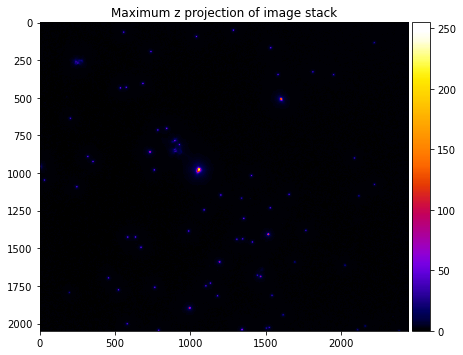

In [21]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(max_proj_norm, cmap=fire)
ax.set_title('Maximum z projection of image stack')
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Find features
The appropriate minimum will vary from dataset to dataset. Here a number of minimum masses are experimented with so that the user can select the value they find appropriate.

  0%|          | 0/6 [00:00<?, ?it/s]

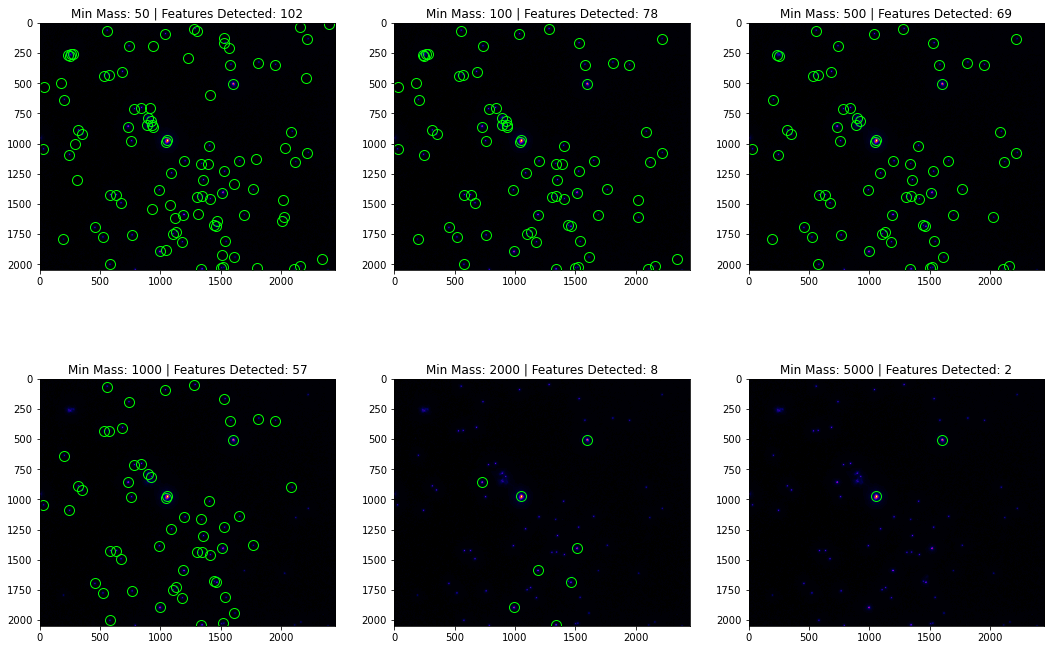

In [50]:
# Set up figure
ncols = 3
nrows = int(np.ceil(len(min_masses) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# Loop through candidate minimum masses
for i, min_mass in tqdm(enumerate(min_masses),
                        total=len(min_masses)):

    # Locate features
    features = trackpy.locate(max_proj_norm,
                              diameter=diameters[1:],
                              minmass=min_mass).reset_index(drop=True)

    # Plot max projection image
    ax = axes.flat[i]
    ax.imshow(max_proj_norm, cmap=fire)
    # Plot detected features
    ax.plot(features['x'], features['y'], ls='', color='#00ff00',
            marker='o', ms=10, mfc='none', mew=1)
    title = f'Min Mass: {min_mass} | Features Detected: {len(features):.0f}'
    ax.set_title(title)

#### Find features with chosen minimum mass

In [54]:
# Update value
min_mass = 750

# Locate features
features = trackpy.locate(max_proj_norm,
                          diameter=diameters[1:],
                          minmass=min_mass).reset_index(drop=True)
# Display a sample of located features
features.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


### Filter features